
# 🧠 Robust Multimodal Emotion & Strategy Classifier (ResNet + Audio + Text)

This notebook includes:
- Balanced CSV loading  
- Safe image/audio reading (graceful failure logging)  
- Debug mode with `num_workers=0`  
- Full train/val loop  
- Save and reload trained model


In [1]:

import os, random, json, numpy as np, pandas as pd
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchaudio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Config
CSV_PATH = 'MESC_cleaned_no_path.csv'
FRAME_COLS = [f'Frame_{i}' for i in range(1,13)]
TEXT_COL, EMOTION_COL, STRATEGY_COL = 'Utterance','Emotion','Strategy'
SAMPLE_RATE, N_MELS = 16000, 128
BATCH_SIZE, EPOCHS, LR = 128, 10, 2e-4
NUM_WORKERS = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


In [2]:

# Load CSV and encode
df = pd.read_csv(CSV_PATH).dropna(subset=[TEXT_COL,EMOTION_COL,STRATEGY_COL,'Audio']+FRAME_COLS)
le_e, le_s = LabelEncoder().fit(df[EMOTION_COL]), LabelEncoder().fit(df[STRATEGY_COL])
df['emotion_id'], df['strategy_id'] = le_e.transform(df[EMOTION_COL]), le_s.transform(df[STRATEGY_COL])
num_emotions, num_strategies = len(le_e.classes_), len(le_s.classes_)
print(num_emotions,"emotions", num_strategies,"strategies")
train_df, val_df = train_test_split(df,test_size=0.15,random_state=42,stratify=df['emotion_id'])


7 emotions 10 strategies


In [3]:

# Safe loaders
def safe_img(path):
    try:
        path=os.path.normpath(path)
        return Image.open(path).convert('L')
    except Exception as e:
        raise RuntimeError(f"Image failed: {path} -> {e}")
import soundfile as sf
import torchaudio.functional as F

def safe_audio(path):
    try:
        path = os.path.normpath(path)
        # Read using libsndfile backend
        wav, sr = sf.read(path, dtype='float32', always_2d=False)
        wav = torch.tensor(wav, dtype=torch.float32)
        if wav.ndim > 1:  # stereo → mono
            wav = wav.mean(dim=-1)
        wav = wav.unsqueeze(0)  # shape [1, T]
        if sr != SAMPLE_RATE:
            wav = F.resample(wav, sr, SAMPLE_RATE)
        return wav
    except Exception as e:
        raise RuntimeError(f"Audio failed: {path} -> {e}")



In [4]:

img_tf=transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])
melspec=torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE,n_mels=N_MELS)
amp2db=torchaudio.transforms.AmplitudeToDB()

class ClipDS(Dataset):
    def __init__(self,df):self.df=df.reset_index(drop=True)
    def __len__(self):return len(self.df)
    def __getitem__(self,i):
        try:
            row=self.df.loc[i]
            fr=[img_tf(safe_img(row[c])) for c in FRAME_COLS]
            wav=safe_audio(row['Audio'])
            mel=amp2db(melspec(wav)).squeeze(0).mean(-1)
            return {'utt':row[TEXT_COL],'frames_12':torch.stack(fr),
                    'audio_feat':mel,'emo':int(row['emotion_id']),'strat':int(row['strategy_id'])}
        except Exception as e:raise RuntimeError(f"Idx {i}: {e}")


C:\Users\Ezaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchaudio\functional\functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [5]:

def tok(texts,max_len=64):
    arr=[[ord(c)%10000 for c in t][:max_len] for t in texts]
    L=max(len(a) for a in arr)
    x=torch.zeros(len(arr),L).long()
    for i,a in enumerate(arr):x[i,:len(a)]=torch.tensor(a)
    return x,torch.ones_like(x)
def collate(b):
    ids,att=tok([x['utt'] for x in b])
    fr=torch.stack([x['frames_12'] for x in b])
    au=torch.stack([x['audio_feat'] for x in b])
    e=torch.tensor([x['emo'] for x in b]);s=torch.tensor([x['strat'] for x in b])
    return {'input_ids':ids,'att':att,'frames':fr,'audio':au,'emo':e,'strat':s}

train_dl=DataLoader(ClipDS(train_df),batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS,collate_fn=collate)
val_dl=DataLoader(ClipDS(val_df),batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,collate_fn=collate)
print("Train:",len(train_dl.dataset))


Train: 10639


In [6]:
from torchvision import models
import torch
import torch.nn as nn
import math

# --- Vision backbone: MobileNetV3-Small for 1-channel input, outputs 576-d ---
def mobilenet_gray():
    m = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)

    # Replace first 3->C conv with 1->C conv and port averaged weights
    first = m.features[0][0]  # Conv2d inside ConvBNActivation
    w = first.weight.mean(1, keepdim=True).clone()  # [C,1,3,3]
    m.features[0][0] = nn.Conv2d(
        in_channels=1,
        out_channels=first.out_channels,
        kernel_size=first.kernel_size,
        stride=first.stride,
        padding=first.padding,
        bias=False,
    )
    m.features[0][0].weight.data = w

    # Make it a feature extractor (global pooled 576-d, classifier removed)
    m.classifier = nn.Identity()
    return m, 576

# --- Text encoder (lighter: same hidden size, fewer heads/layers) ---
class TxtEnc(nn.Module):
    def __init__(self, h=512):
        super().__init__()
        self.emb = nn.Embedding(10000, h)
        e = nn.TransformerEncoderLayer(h, 4, batch_first=True)  # heads=4
        self.enc = nn.TransformerEncoder(e, 1)                  # layers=1

    def forward(self, ids, att):
        x = self.emb(ids)
        return self.enc(x), x[:, 0, :]  # (seq_enc, "cls"-like first token)

# --- Small audio encoder over Mel axis ---
class AudioEnc(nn.Module):
    """
    Input:  [B, N_MELS]
    Output: [B, 512]
    """
    def __init__(self, n_mels, d=512, mid_ch=64, se_ratio=8):
        super().__init__()
        # Depthwise-separable 1D convs along Mel bins
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, mid_ch, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm1d(mid_ch),
            nn.GELU(),
        )
        self.dw2 = nn.Sequential(
            nn.Conv1d(mid_ch, mid_ch, kernel_size=5, padding=2, groups=mid_ch, bias=False),
            nn.BatchNorm1d(mid_ch),
            nn.GELU(),
        )
        self.pw2 = nn.Sequential(
            nn.Conv1d(mid_ch, mid_ch, kernel_size=1, bias=False),
            nn.BatchNorm1d(mid_ch),
            nn.GELU(),
        )
        # Squeeze-Excitation over channel dim (on conv features)
        se_hidden = max(4, mid_ch // se_ratio)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),                    # [B,C,1]
            nn.Flatten(),                               # [B,C]
            nn.Linear(mid_ch, se_hidden), nn.GELU(),
            nn.Linear(se_hidden, mid_ch), nn.Sigmoid(), # [B,C]
        )
        # Head: global pool over Mel, project to 512
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),  # [B,C,1]
            nn.Flatten(),             # [B,C]
            nn.Linear(mid_ch, d),
        )

    def forward(self, x):  # x: [B, N_MELS]
        x = x.unsqueeze(1)                 # [B,1,M]
        x = self.conv1(x)                  # [B,C,M]
        y = self.dw2(x)                    # [B,C,M]
        y = self.pw2(y)                    # [B,C,M]
        # SE gate
        w = self.se(y)                     # [B,C]
        y = y * w.unsqueeze(-1)            # [B,C,M]
        z = self.head(y)                   # [B,512]
        return z

# --- Net with text-guided temporal top-k pooling + improved audio + trainable fusion ---
class Net(nn.Module):
    """
    Multimodal Net with:
      • Vision: MobileNetV3-Small (grayscale) → per-frame 512-d
      • Text:   tiny Transformer → sequence [B,T,512], CLS [B,512]
      • Text-guided temporal top-k pooling over 12 frames (hard select)
      • Audio:  lightweight 1D conv encoder over Mel → 512-d
      • Fusion: trainable per-channel gate g = sigmoid(w), fused = g*v + (1-g)*a
      • Cross-attn: text (queries) attends to fused AV (keys/values)
    Returns:
      emo_logits:   [B, num_emotions]
      strat_logits: [B, num_strategies]
      topk_idx:     [B, K] indices of selected frames (0..11)
    """
    def __init__(self, top_k=6):
        super().__init__()
        # Vision
        self.v, v_dim = mobilenet_gray()   # v_dim = 576
        self.vp = nn.Linear(v_dim, 512)    # per-frame -> 512

        # Audio (enhanced)
        self.aenc = AudioEnc(N_MELS, d=512, mid_ch=64, se_ratio=8)

        # Text
        self.t = TxtEnc()

        # Text-guided pooling projections
        self.f_key   = nn.Linear(512, 512, bias=False)  # frames -> keys
        self.t_query = nn.Linear(512, 512, bias=False)  # text  -> query
        self.top_k = top_k

        # Trainable per-channel fusion gate g ∈ (0,1)^512
        self.fuse_w = nn.Parameter(torch.zeros(512))    # sigmoid(0)=0.5

        # Cross-attention
        self.q  = nn.Linear(512, 512)
        self.k  = nn.Linear(512, 512)
        self.vv = nn.Linear(512, 512)
        self.att = nn.MultiheadAttention(512, 8, batch_first=True)

        # Heads
        self.he = nn.Linear(512, num_emotions)
        self.hs = nn.Linear(512, num_strategies)

    def forward(self, fr, au, t):
        """
        fr: [B,12,1,128,128]  grayscale frames
        au: [B, N_MELS]       Mel features
        t : {'input_ids': [B,T], 'att': [B,T]}
        """
        B = fr.size(0)

        # --- Text encoding (to get query) ---
        seq, cls = self.t(t['input_ids'], t['att'])   # seq:[B,T,512], cls:[B,512]
        qtxt = self.t_query(cls).unsqueeze(1)         # [B,1,512]

        # --- Vision: encode 12 frames individually ---
        vf = self.v(fr.view(B * 12, 1, 128, 128))     # [B*12, 576]
        vf = self.vp(vf).view(B, 12, 512)             # [B,12,512]
        kf = self.f_key(vf)                           # [B,12,512]

        # --- Text-guided scores over frames (scaled dot-product) ---
        scores = (qtxt * kf).sum(-1) / math.sqrt(512) # [B,12]

        # --- Select top-K frames and average them ---
        topk_vals, topk_idx = scores.topk(self.top_k, dim=1)         # [B,K], [B,K]
        gather_idx = topk_idx.unsqueeze(-1).expand(-1, -1, vf.size(-1))  # [B,K,512]
        vf_topk = torch.gather(vf, dim=1, index=gather_idx)               # [B,K,512]
        v = vf_topk.mean(1)                                               # [B,512]

        # --- Audio (enhanced) ---
        a = self.aenc(au)                         # [B,512]

        # --- Trainable weighted fusion (per-channel gate) ---
        g = torch.sigmoid(self.fuse_w).view(1, -1)  # [1,512]
        av = g * v + (1.0 - g) * a                  # [B,512]
        av = av.unsqueeze(1)                        # [B,1,512]

        # --- Cross-attention with text sequence ---
        qx, kx, vx = self.q(seq), self.k(av), self.vv(av)
        o, _ = self.att(qx, kx, vx)                 # [B,T,512]
        fz = o[:, 0, :]                              # [B,512]

        # --- Predict ---
        emo = self.he(fz)
        strat = self.hs(fz)

        # also return which frames were selected
        return emo, strat, topk_idx







model = Net().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=LR)
ce = nn.CrossEntropyLoss()


In [9]:
from tqdm import tqdm
import torch

def run_epoch(model, dl, train=True, track_frames=False):
    """
    train         : toggles model.train()/eval() and grad
    track_frames  : if True, returns a histogram of how often each frame idx (0..11) was selected
    """
    model.train(train)
    total_emo_loss, total_str_loss = 0.0, 0.0
    correct_emo, correct_str = 0, 0
    total_samples = 0

    # optional frame-selection tracking
    frame_hist = torch.zeros(12, dtype=torch.long) if track_frames else None

    phase = "Train" if train else "Val"
    pbar = tqdm(dl, desc=f"{phase} epoch", leave=False)

    for batch in pbar:
        # ---------------- Inputs ----------------
        frames = batch['frames'].to(device)           # [B,12,1,128,128]
        audio  = batch['audio'].to(device)            # [B, N_MELS]
        emo_gt = batch['emo'].to(device)              # [B]
        strat_gt = batch['strat'].to(device)          # [B]
        text = {
            'input_ids': batch['input_ids'].to(device),   # [B,T]
            'att': batch['att'].to(device)                # [B,T]
        }

        # ---------------- Forward / Backward ----------------
        with torch.set_grad_enabled(train):
            # NEW: model returns (emo_pred, strat_pred, topk_idx)
            emo_pred, strat_pred, topk_idx = model(frames, audio, text)   # topk_idx: [B,K]

            loss_emo = ce(emo_pred, emo_gt)
            loss_str = ce(strat_pred, strat_gt)
            total_loss = loss_emo + loss_str

            if train:
                opt.zero_grad(set_to_none=True)
                total_loss.backward()
                opt.step()

        # ---------------- Metrics ----------------
        bs = frames.size(0)
        total_samples += bs
        total_emo_loss += loss_emo.item() * bs
        total_str_loss += loss_str.item() * bs
        correct_emo += (emo_pred.argmax(1) == emo_gt).sum().item()
        correct_str += (strat_pred.argmax(1) == strat_gt).sum().item()

        # track which frame positions are being picked (only if requested)
        if track_frames:
            # topk_idx is [B,K]; count occurrences per position 0..11
            # move to cpu for bincount
            sel = topk_idx.detach().reshape(-1).to('cpu')
            # ensure length covers 12 bins
            counts = torch.bincount(sel, minlength=12)
            frame_hist += counts.to(frame_hist.dtype)

        # live display
        pbar.set_postfix({
            "EmoLoss": f"{loss_emo.item():.3f}",
            "StrLoss": f"{loss_str.item():.3f}"
        })

    avg_emo_loss = total_emo_loss / max(1, total_samples)
    avg_str_loss = total_str_loss / max(1, total_samples)
    emo_acc = correct_emo / max(1, total_samples)
    strat_acc = correct_str / max(1, total_samples)

    out = {
        "emo_loss": avg_emo_loss,
        "emo_acc": emo_acc,
        "str_loss": avg_str_loss,
        "str_acc": strat_acc
    }
    if track_frames:
        out["topk_hist"] = frame_hist.tolist()  # length-12 list for convenience
    return out


# ---------------- Training Loop ----------------
history = []
# Use your global EPOCHS value consistently
for ep in range(1, 20 + 1):
    print(f"\n🟩 Epoch {ep}/{EPOCHS}")
    train_metrics = run_epoch(model, train_dl, train=True,  track_frames=False)
    val_metrics   = run_epoch(model, val_dl,   train=False, track_frames=True)  # track on val

    print(f"📊 Train — "
          f"Emotion Loss: {train_metrics['emo_loss']:.4f}, "
          f"Acc: {train_metrics['emo_acc']*100:.2f}% | "
          f"Strategy Loss: {train_metrics['str_loss']:.4f}, "
          f"Acc: {train_metrics['str_acc']*100:.2f}%")

    print(f"🧪 Val   — "
          f"Emotion Loss: {val_metrics['emo_loss']:.4f}, "
          f"Acc: {val_metrics['emo_acc']*100:.2f}% | "
          f"Strategy Loss: {val_metrics['str_loss']:.4f}, "
          f"Acc: {val_metrics['str_acc']*100:.2f}%")

    # If you want to see which frame positions are most often selected on Val:
    if 'topk_hist' in val_metrics:
        hist = val_metrics['topk_hist']  # list of 12 ints
        print(f"🎯 Val frame-selection histogram (idx 0..11): {hist}")

    history.append((train_metrics, val_metrics))

# save + consistent message
save_path = "robust_avt_model2.pth"
torch.save(model.state_dict(), save_path)
print(f"\n✅ Model saved as {save_path}")



🟩 Epoch 1/10


📊 Train — Emotion Loss: 0.6170, Acc: 77.58% | Strategy Loss: 1.1408, Acc: 58.02%
🧪 Val   — Emotion Loss: 8.6182, Acc: 8.73% | Strategy Loss: 4.2619, Acc: 14.43%
🎯 Val frame-selection histogram (idx 0..11): [901, 855, 891, 984, 974, 886, 896, 939, 993, 976, 999, 974]

🟩 Epoch 2/10


📊 Train — Emotion Loss: 0.2719, Acc: 90.88% | Strategy Loss: 0.6205, Acc: 76.91%
🧪 Val   — Emotion Loss: 10.6481, Acc: 11.98% | Strategy Loss: 6.5854, Acc: 14.43%
🎯 Val frame-selection histogram (idx 0..11): [985, 984, 920, 959, 912, 959, 903, 943, 942, 893, 913, 955]

🟩 Epoch 3/10


📊 Train — Emotion Loss: 0.1591, Acc: 94.85% | Strategy Loss: 0.3716, Acc: 86.97%
🧪 Val   — Emotion Loss: 9.1890, Acc: 19.76% | Strategy Loss: 7.6438, Acc: 11.40%
🎯 Val frame-selection histogram (idx 0..11): [896, 903, 909, 962, 930, 1015, 934, 902, 962, 1002, 874, 979]

🟩 Epoch 4/10


📊 Train — Emotion Loss: 0.1023, Acc: 96.79% | Strategy Loss: 0.1929, Acc: 93.98%
🧪 Val   — Emotion Loss: 8.4938, Acc: 26.41% | Strategy Loss: 9.9665, Acc: 12.35%
🎯 Val frame-selection histogram (idx 0..11): [925, 908, 988, 935, 906, 993, 904, 907, 926, 968, 989, 919]

🟩 Epoch 5/10


📊 Train — Emotion Loss: 0.0735, Acc: 97.71% | Strategy Loss: 0.1734, Acc: 94.66%
🧪 Val   — Emotion Loss: 7.7332, Acc: 32.32% | Strategy Loss: 8.4988, Acc: 19.97%
🎯 Val frame-selection histogram (idx 0..11): [976, 929, 977, 957, 909, 981, 941, 869, 977, 946, 935, 871]

🟩 Epoch 6/10


📊 Train — Emotion Loss: 0.0659, Acc: 98.04% | Strategy Loss: 0.1073, Acc: 97.04%
🧪 Val   — Emotion Loss: 6.0117, Acc: 37.06% | Strategy Loss: 6.3133, Acc: 24.87%
🎯 Val frame-selection histogram (idx 0..11): [963, 895, 975, 1025, 916, 954, 917, 897, 922, 933, 971, 900]

🟩 Epoch 7/10


📊 Train — Emotion Loss: 0.0979, Acc: 96.89% | Strategy Loss: 0.1549, Acc: 95.58%
🧪 Val   — Emotion Loss: 3.2837, Acc: 49.31% | Strategy Loss: 3.7752, Acc: 38.87%
🎯 Val frame-selection histogram (idx 0..11): [982, 997, 940, 962, 921, 919, 899, 948, 938, 942, 902, 918]

🟩 Epoch 8/10


📊 Train — Emotion Loss: 0.0442, Acc: 98.68% | Strategy Loss: 0.0796, Acc: 97.86%
🧪 Val   — Emotion Loss: 2.7067, Acc: 55.96% | Strategy Loss: 3.5489, Acc: 46.49%
🎯 Val frame-selection histogram (idx 0..11): [956, 920, 998, 981, 905, 952, 944, 926, 939, 885, 966, 896]

🟩 Epoch 9/10


📊 Train — Emotion Loss: 0.0439, Acc: 98.70% | Strategy Loss: 0.0854, Acc: 97.59%
🧪 Val   — Emotion Loss: 2.1014, Acc: 64.96% | Strategy Loss: 2.6239, Acc: 54.47%
🎯 Val frame-selection histogram (idx 0..11): [965, 909, 981, 992, 920, 956, 946, 967, 941, 857, 943, 891]

🟩 Epoch 10/10


📊 Train — Emotion Loss: 0.0177, Acc: 99.50% | Strategy Loss: 0.0453, Acc: 98.81%
🧪 Val   — Emotion Loss: 1.7165, Acc: 69.70% | Strategy Loss: 1.6583, Acc: 67.25%
🎯 Val frame-selection histogram (idx 0..11): [976, 983, 931, 965, 955, 907, 954, 928, 933, 882, 937, 917]

🟩 Epoch 11/10


📊 Train — Emotion Loss: 0.0263, Acc: 99.30% | Strategy Loss: 0.0624, Acc: 98.46%
🧪 Val   — Emotion Loss: 0.1954, Acc: 94.20% | Strategy Loss: 0.2413, Acc: 92.60%
🎯 Val frame-selection histogram (idx 0..11): [980, 978, 940, 944, 881, 942, 910, 939, 975, 907, 970, 902]

🟩 Epoch 12/10


📊 Train — Emotion Loss: 0.0479, Acc: 98.44% | Strategy Loss: 0.0695, Acc: 97.95%
🧪 Val   — Emotion Loss: 0.1706, Acc: 95.79% | Strategy Loss: 0.2285, Acc: 93.50%
🎯 Val frame-selection histogram (idx 0..11): [945, 997, 841, 965, 901, 941, 931, 984, 965, 958, 963, 877]

🟩 Epoch 13/10


📊 Train — Emotion Loss: 0.0224, Acc: 99.31% | Strategy Loss: 0.0811, Acc: 97.68%
🧪 Val   — Emotion Loss: 0.0814, Acc: 98.03% | Strategy Loss: 0.1515, Acc: 96.27%
🎯 Val frame-selection histogram (idx 0..11): [974, 951, 909, 960, 918, 999, 951, 923, 970, 972, 913, 828]

🟩 Epoch 14/10


📊 Train — Emotion Loss: 0.0350, Acc: 98.81% | Strategy Loss: 0.0460, Acc: 98.79%
🧪 Val   — Emotion Loss: 0.1179, Acc: 98.03% | Strategy Loss: 0.0972, Acc: 97.50%
🎯 Val frame-selection histogram (idx 0..11): [925, 940, 958, 915, 916, 978, 905, 948, 942, 974, 936, 931]

🟩 Epoch 15/10


📊 Train — Emotion Loss: 0.1175, Acc: 96.76% | Strategy Loss: 0.0961, Acc: 97.04%
🧪 Val   — Emotion Loss: 0.1898, Acc: 94.94% | Strategy Loss: 0.2580, Acc: 92.76%
🎯 Val frame-selection histogram (idx 0..11): [888, 912, 931, 897, 868, 981, 1008, 992, 936, 921, 992, 942]

🟩 Epoch 16/10


📊 Train — Emotion Loss: 0.0230, Acc: 99.28% | Strategy Loss: 0.0604, Acc: 98.19%
🧪 Val   — Emotion Loss: 0.0654, Acc: 98.24% | Strategy Loss: 0.1303, Acc: 97.76%
🎯 Val frame-selection histogram (idx 0..11): [976, 921, 959, 949, 899, 978, 1018, 928, 976, 878, 920, 866]

🟩 Epoch 17/10


📊 Train — Emotion Loss: 0.0533, Acc: 98.47% | Strategy Loss: 0.0603, Acc: 98.15%
🧪 Val   — Emotion Loss: 0.1045, Acc: 97.39% | Strategy Loss: 0.1524, Acc: 96.27%
🎯 Val frame-selection histogram (idx 0..11): [910, 932, 992, 940, 933, 1034, 992, 993, 894, 845, 890, 913]

🟩 Epoch 18/10


📊 Train — Emotion Loss: 0.0314, Acc: 99.02% | Strategy Loss: 0.0573, Acc: 98.25%
🧪 Val   — Emotion Loss: 0.0528, Acc: 98.67% | Strategy Loss: 0.0972, Acc: 97.98%
🎯 Val frame-selection histogram (idx 0..11): [973, 889, 982, 955, 914, 998, 968, 937, 906, 911, 931, 904]

🟩 Epoch 19/10


📊 Train — Emotion Loss: 0.0596, Acc: 98.39% | Strategy Loss: 0.0737, Acc: 97.89%
🧪 Val   — Emotion Loss: 0.0735, Acc: 98.35% | Strategy Loss: 0.1843, Acc: 95.95%
🎯 Val frame-selection histogram (idx 0..11): [949, 885, 986, 961, 900, 988, 960, 906, 932, 926, 940, 935]

🟩 Epoch 20/10


📊 Train — Emotion Loss: 0.0082, Acc: 99.75% | Strategy Loss: 0.0287, Acc: 99.16%
🧪 Val   — Emotion Loss: 0.0388, Acc: 99.31% | Strategy Loss: 0.0686, Acc: 98.40%
🎯 Val frame-selection histogram (idx 0..11): [928, 894, 954, 1011, 924, 1009, 970, 922, 943, 905, 909, 899]

✅ Model saved as robust_avt_model2.pth


In [10]:
from PIL import Image
import torch

def predict_sample(model, frame_paths, audio_path, utterance, le_emotion, le_strategy):
    """
    frame_paths: list of 12 grayscale 128x128 image paths
    audio_path : path to WAV file
    utterance  : text (string)
    le_emotion, le_strategy: trained label encoders

    Returns:
        emotion (str), strategy (str),
        selected_idx (list[int]), selected_paths (list[str])
    """

    # --- Preprocess frames ---
    frames = [img_tf(safe_img(p)) for p in frame_paths]     # each -> [1,128,128]
    frames = torch.stack(frames).unsqueeze(0).to(device)    # [1,12,1,128,128]

    # --- Preprocess audio ---
    wav = safe_audio(audio_path)
    mel = amp2db(melspec(wav)).squeeze(0).mean(-1)         # [N_MELS]
    mel = mel.unsqueeze(0).to(device)                      # [1, N_MELS]

    # --- Text tokens ---
    ids, att = tok([utterance])
    text = {'input_ids': ids.to(device), 'att': att.to(device)}

    # --- Forward pass ---
    with torch.no_grad():
        emo_pred, strat_pred, topk_idx = model(frames, mel, text)  # topk_idx: [1,K]
        emo_id   = emo_pred.argmax(1).item()
        strat_id = strat_pred.argmax(1).item()
        selected_idx = topk_idx[0].tolist()                        # order: by score (desc)
        selected_paths = [frame_paths[i] for i in selected_idx]

    # --- Decode labels ---
    emotion = le_emotion.inverse_transform([emo_id])[0]
    strategy = le_strategy.inverse_transform([strat_id])[0]

    # --- Logs ---
    print(f"🧩 Predicted Emotion:  {emotion}")
    print(f"🗣️  Predicted Strategy: {strategy}")
    print(f"🎯 Selected frames (by relevance score, desc): {selected_idx}")
    print("    Paths:")
    for i in selected_idx:
        print(f"     - [{i}] {frame_paths[i]}")

    return emotion, strategy, selected_idx, selected_paths


In [11]:
import matplotlib.pyplot as plt
from IPython.display import Audio, display

def show_prediction_sample(model, df, le_emotion, le_strategy):
    """
    Randomly picks one row from df, visualizes 12 frames (highlighting the
    model-selected frames), plays audio, shows utterance, and prints predicted
    + true labels. Also shows a second grid with only the selected frames in
    temporal order.
    """

    row = df.sample(1).iloc[0]
    frame_paths = [row[f] for f in FRAME_COLS]
    audio_path  = row['Audio']
    utterance   = row['Utterance']

    print("="*90)
    print(f"🎬 Utterance: {utterance}")
    print(f"🎧 Audio: {audio_path}")
    print("="*90)

    # --- Run prediction first (so we know which frames to highlight) ---
    pred_emotion, pred_strategy, selected_idx, selected_paths = predict_sample(
        model,
        frame_paths=frame_paths,
        audio_path=audio_path,
        utterance=utterance,
        le_emotion=le_emotion,
        le_strategy=le_strategy
    )
    sel_set = set(selected_idx)  # for quick lookup

    # --- Display all 12 frames, highlighting selected ones ---
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for i, (ax, path) in enumerate(zip(axes.flatten(), frame_paths)):
        try:
            img = Image.open(path).convert("L")
            ax.imshow(img, cmap='gray')
            is_sel = (i in sel_set)
            title = f"Frame {i} {'✓' if is_sel else ''}"
            ax.set_title(title, fontsize=10)
            # highlight selected frames with a thicker red border
            for spine in ax.spines.values():
                spine.set_linewidth(3.0 if is_sel else 0.5)
                spine.set_edgecolor('red' if is_sel else 'black')
            ax.axis("off")
        except Exception as e:
            ax.text(0.5, 0.5, "Missing", ha='center', va='center')
            ax.axis("off")
    plt.tight_layout()
    plt.show()

    # --- Show only selected frames (in temporal order) ---
    if len(selected_idx) > 0:
        sel_temporal = sorted(selected_idx)
        rows = 2
        cols = (len(sel_temporal) + 1) // 2  # 2 rows layout
        fig2, axes2 = plt.subplots(rows, cols, figsize=(3.5*cols, 6))
        axes2 = axes2 if isinstance(axes2, (list, np.ndarray)) else [axes2]
        axes2 = [ax for row_axes in (axes2 if isinstance(axes2, np.ndarray) else [axes2]) 
                 for ax in (row_axes if isinstance(row_axes, np.ndarray) else [row_axes])]
        for j, ax in enumerate(axes2):
            if j < len(sel_temporal):
                idx = sel_temporal[j]
                try:
                    img = Image.open(frame_paths[idx]).convert("L")
                    ax.imshow(img, cmap='gray')
                    ax.set_title(f"Selected Frame {idx}", fontsize=10)
                    for spine in ax.spines.values():
                        spine.set_linewidth(3.0)
                        spine.set_edgecolor('red')
                    ax.axis("off")
                except Exception:
                    ax.text(0.5, 0.5, "Missing", ha='center', va='center')
                    ax.axis("off")
            else:
                ax.axis("off")
        plt.tight_layout()
        plt.show()

    # --- Play audio ---
    print("🔊 Playing audio:")
    display(Audio(audio_path, autoplay=False))

    # --- Labels (pred vs. true) ---
    true_emotion  = row[EMOTION_COL]
    true_strategy = row[STRATEGY_COL]
    print("\n================= RESULT SUMMARY =================")
    print(f"🧩 Predicted Emotion:  {pred_emotion}")
    print(f"🗣️  Predicted Strategy: {pred_strategy}")
    print(f"🎯 True Emotion:        {true_emotion}")
    print(f"🎯 True Strategy:       {true_strategy}")
    print(f"🎯 Selected frames (by score desc): {selected_idx}")
    print(f"🕒 Selected frames (temporal order): {sorted(selected_idx)}")
    print("===================================================")

    return row, selected_idx, selected_paths


🎬 Utterance: Are you saying that I pushed Kate into this situation? That I created this environment at home so that Kate could go fuck an insurance agent because really I'm in love with Laura? Isn't that your theory? Your notes somewhere?
🎧 Audio: audio\Dialogue_ID-125_Season-1_Episode-10_00-21-43.188_00-21-58.339.wav
🧩 Predicted Emotion:  anger
🗣️  Predicted Strategy: Others
🎯 Selected frames (by relevance score, desc): [9, 8, 10, 4, 2, 7]
    Paths:
     - [9] frames\Dialogue_ID-125_Season-1_Episode-10_f10_t001314843.png
     - [8] frames\Dialogue_ID-125_Season-1_Episode-10_f09_t001313677.png
     - [10] frames\Dialogue_ID-125_Season-1_Episode-10_f11_t001316008.png
     - [4] frames\Dialogue_ID-125_Season-1_Episode-10_f05_t001309015.png
     - [2] frames\Dialogue_ID-125_Season-1_Episode-10_f03_t001306684.png
     - [7] frames\Dialogue_ID-125_Season-1_Episode-10_f08_t001312512.png


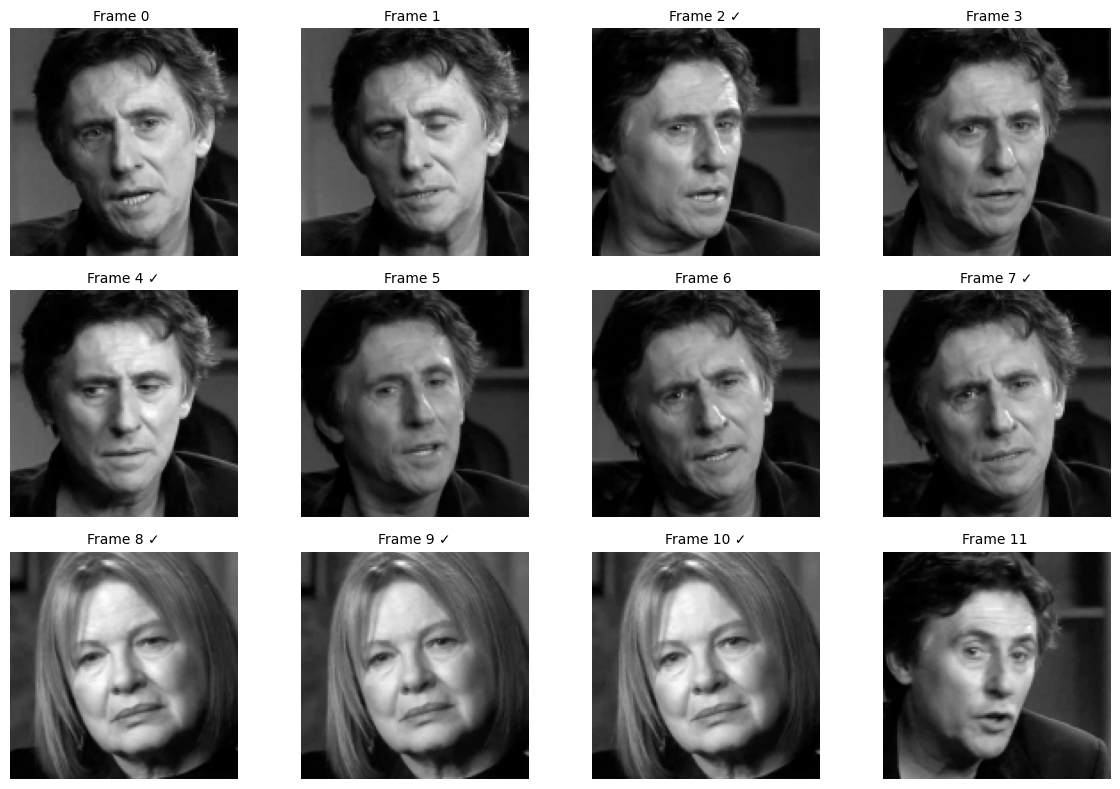

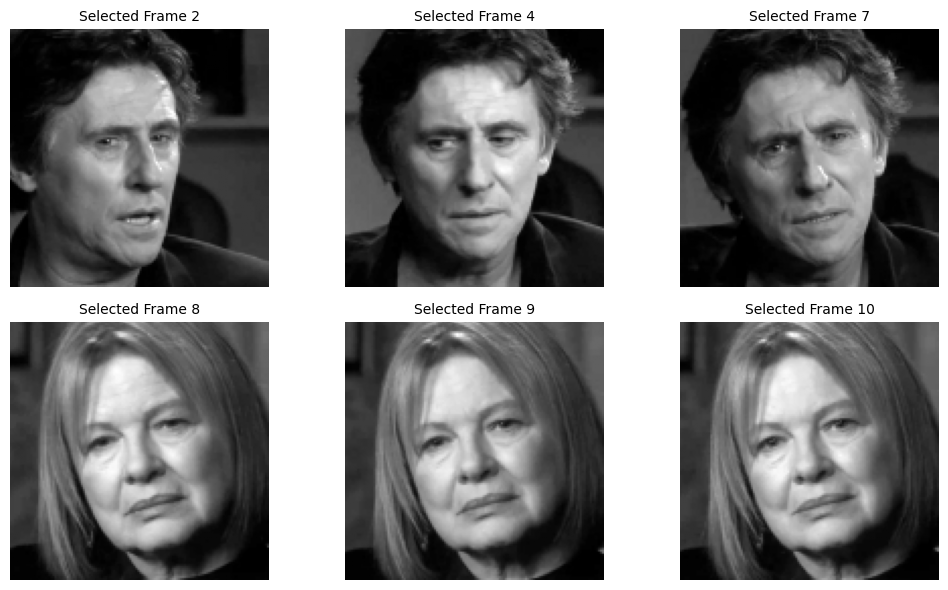

🔊 Playing audio:



================= RESULT SUMMARY =================
🧩 Predicted Emotion:  anger
🗣️  Predicted Strategy: Others
🎯 True Emotion:        anger
🎯 True Strategy:       Others
🎯 Selected frames (by score desc): [9, 8, 10, 4, 2, 7]
🕒 Selected frames (temporal order): [2, 4, 7, 8, 9, 10]


(Dialogue_ID                                                   125
 split_group                                                     0
 Season                                                          1
 Episode                                                        10
 StartTime                                            00:21:43,188
 EndTime                                              00:21:58,339
 Speaker                                                    Client
 Utterance       Are you saying that I pushed Kate into this si...
 Emotion                                                     anger
 Strategy                                                   Others
 Utterance_ID                                                    0
 Frame_1         frames\Dialogue_ID-125_Season-1_Episode-10_f01...
 Frame_2         frames\Dialogue_ID-125_Season-1_Episode-10_f02...
 Frame_3         frames\Dialogue_ID-125_Season-1_Episode-10_f03...
 Frame_4         frames\Dialogue_ID-125_Season-1_Episode-10_f0

In [12]:

# Load trained model and encoders first (if not already)
model_loaded = Net().to(device)
model_loaded.load_state_dict(torch.load("robust_avt_model2.pth", map_location=device))
model_loaded.eval()

# Now predict on a random CSV row
show_prediction_sample(model_loaded, df, le_e, le_s)

